# Project 4: Web Scraping Indeed.com & Predicting Salaries

In Project 4, we practice two major skills: collecting data via  web scraping and building a binary predictor with Logistic Regression.

We will collect salary information on data science jobs in a variety of markets. Using location, title, and job summary, we'll predict the salary of the job. For job posting sites, this is extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), extrapolating expected salary can help guide negotiations.

Normally, we can use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Q: Why would we want this to be a classification problem?
- A: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Section one focuses on scraping Indeed.com; then we use listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

Scrape job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries. First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract.

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [2]:
# import sys
# reload(sys)
# sys.setdefaultencoding('utf-8')

import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import statsmodels.formula.api as sm
import re
import numpy as np
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from patsy import dmatrix
from sklearn.metrics import confusion_matrix, classification_report, recall_score, roc_auc_score, roc_curve, auc, accuracy_score, precision_score
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
# import geocoder
# from geopy.geocoders import Nominatim
# from geopy.distance import vincenty
%matplotlib inline


In [3]:
URL = "http://www.indeed.com/jobs?q=data+scientist"

r = requests.get(URL)
soup = BeautifulSoup(r.content, "lxml")

results = soup.findAll('div', { "class" : "result" })

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some of the more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```

- Make sure these functions are robust and can handle cases where the data/field may not be available
- Test the functions on the results above

In [4]:
# get text
def extract_text(el):
    if el:
        return el.text.strip()
    else:
        return ''
        
# company
def get_company_from_result(result):
    return extract_text(result.find('span', {'class' : 'company'}))
    
# location
def get_location_from_result(result):
    return extract_text(result.find('span', {'class' : 'location'}))

# summary
def get_summary_from_result(result):
    return extract_text(result.find('span', {'class' : 'summary'}))

# title
def get_title_from_result(result):
    return extract_text(result.find('a', {'data-tn-element' : 'jobTitle'}))

# get salary if exists
def get_salary_from_result(result):
    salary_table = result.find('td', {'class' : 'snip'})
    if salary_table:
        snip = salary_table.find('nobr')
        if snip:
            return snip.text.strip()   
    return None


# def get_sponsored_from_result(result):
#     return extract_text(result.find('span', {'class' : 'sdn'}))

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results: the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try different city). The second controls where in the results to start and gives 10 results (so we can keep incrementing this by 10 to move further within the list).

#### Complete the following code to collect results from multiple cities and start points. 
- Enter your city below to add it to the search
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

In [5]:
# specify city
cities = ['Georgia', 'New+York', 'San+Francisco', 'Boston', 'San+Diego', 'Chicago', 'Washington', 'Los+Angeles', 'California', 'Maryland', 'Texas', 'Minnesota', 'Florida', 'North+Carolina', 'South+Carolina']

In [6]:
# create template URL and max number of results (pages) to pull
url_template = "http://www.indeed.com/jobs?q=data+scientist&l={}&start={}"

# for loop to pull data with bs4
for city in set(cities):
    for start in range(0, 200, 10):
        r = requests.get(url_template.format(city, start))
        # Grab the results from the request (as above)
        soup = BeautifulSoup(r.content)
        # Append to the full set of results
        results += soup.findAll('div', { "class" : "result" })

//anaconda/envs/py27/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file //anaconda/envs/py27/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [7]:
# combine data into dictionaries
rows = []
for result in results:
    if result:
        row = {"location":get_location_from_result(result), "company":get_company_from_result(result), "title":get_title_from_result(result), "summary":get_summary_from_result(result), "salary":get_salary_from_result(result)}
    rows.append(row)

# create dataframe
data = pd.DataFrame(rows, columns=['company','location', 'title', 'summary', 'salary'])

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now
1. Some of the entries may be duplicated
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries

In [8]:
# Remove duplicates
df = data.drop_duplicates()
# Filter to only the rows that have salary entries
df = df[df.salary.notnull()]
# Filter out salary entries referring to week, hour or month
df = df[~(df.salary.astype('str').str.contains('hour'))] # example
df = df[~(df.salary.astype('str').str.contains('week'))] 
df = df[~(df.salary.astype('str').str.contains('month'))] 

In [9]:
# save scraped results as a CSV for Tableau/external viz
df.to_csv('salary_data.csv', encoding='utf-8')

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [10]:
# load in the the data of scraped salaries
salary_data = pd.read_csv('salary_data.csv')

In [11]:
del salary_data['Unnamed: 0']

In [12]:
def extract_salary_average(salary_string):
    regex = r'\$([0-9]+,[0-9]+)'
    matches = re.findall(regex, salary_string)
    return np.mean([float(salary.replace(',', '')) for salary in matches ])

In [13]:
salary_data = salary_data[salary_data.salary.notnull()]

In [14]:
# use '.map' to transform salary to new feature
salary_data['salary'] = salary_data['salary'].map(extract_salary_average)

//anaconda/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [15]:
def city_extract(word):
 return word.split(',')[0]

def state_extract(word):
 return word.split(',')[1].split(' ')[1]

In [16]:
salary_data = salary_data[salary_data.location.str.contains(',')] 

In [17]:
salary_data['state'] = pd.DataFrame({'state':salary_data['location'].apply(state_extract)})
salary_data['city'] = pd.DataFrame({'city':salary_data['location'].apply(city_extract)})

In [18]:
del salary_data['location']

## Predicting salaries using Logistic Regression

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

In [19]:
# calculate median and create feature with 1 as high salary
medianSalary = salary_data['salary'].median()

In [20]:
salary_data['high_salary'] = salary_data['salary'].map(lambda x: 1 if x > medianSalary else 0)

### Q: What is the baseline accuracy for this model?

It is 50% if we guess randomly, half the salaries will be below the median and half will be above.

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

In [21]:
# This model keeps giving me a Singular Matrix error every few times I run it with new data. If that happens, it seems
# to work when I pass "method='ncg'" into the .fit()
# create statsmodel and summary
import statsmodels.formula.api as sm
st_model_1 = sm.logit("high_salary ~ city", data=salary_data).fit(method='ncg')
st_model_1.summary()

Optimization terminated successfully.
         Current function value: 0.275294
         Iterations: 17
         Function evaluations: 23
         Gradient evaluations: 39
         Hessian evaluations: 17


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            high_salary   No. Observations:                  140
Model:                          Logit   Df Residuals:                       91
Method:                           MLE   Df Model:                           48
Date:                Tue, 22 Nov 2016   Pseudo R-squ.:                  0.6028
Time:                        16:47:05   Log-Likelihood:                -38.541
converged:                       True   LL-Null:                       -97.026
                                        LLR p-value:                 1.095e-07
==================================================================================================
                                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Intercept                         -8.6534     75.707     -0.114      0.909      -157.036   139.729
city[T.Atlanta]                    9.5007     75.710      0.125      0.900      -138.888   157.889
city[T.Baltimore]                 -6.9113    851.138     -0.008      0.994     -1675.111  1661.289
city[T.Boston]                    22.5266    351.352      0.064      0.949      -666.111   711.165
city[T.Cambridge]                  9.3465     75.717      0.123      0.902      -139.055   157.748
city[T.Carteret County]           -5.5005    840.886     -0.007      0.995     -1653.608  1642.606
city[T.Chapel Hill]               -4.8008    838.143     -0.006      0.995     -1647.532  1637.930
city[T.Charlotte]                 20.3294    351.352      0.058      0.954      -668.308   708.967
city[T.Chatsworth]                -4.8008    838.143     -0.006      0.995     -1647.532  1637.930
city[T.Chicago]                    9.9061     75.711      0.131      0.896      -138.484   158.297
city[T.Clearwater]                 8.6534     75.720      0.114      0.909      -139.755   157.062
city[T.Coral Gables]               6.8616     75.714      0.091      0.928      -141.536   155.259
city[T.Daytona Beach]             -4.8008    838.143     -0.006      0.995     -1647.532  1637.930
city[T.Durham]                    20.3294    351.352      0.058      0.954      -668.308   708.967
city[T.Eglin AFB]                 -4.8008    838.143     -0.006      0.995     -1647.532  1637.930
city[T.Fort George G Meade]       20.3294    351.352      0.058      0.954      -668.308   708.967
city[T.Fort Myers]                -4.8008    838.143     -0.006      0.995     -1647.532  1637.930
city[T.Gainesville]               -4.8008    838.143     -0.006      0.995     -1647.532  1637.930
city[T.Galveston]                 20.3294    351.352      0.058      0.954      -668.308   708.967
city[T.Greenbelt]                 -4.8008    838.143     -0.006      0.995     -1647.532  1637.930
city[T.Greensboro]                -5.5005    840.886     -0.007      0.995     -1653.608  1642.606
city[T.Houston]                   -4.8008    838.143     -0.006      0.995     -1647.532  1637.930
city[T.Jacksonville]              20.3294    351.352      0.058      0.954      -668.308   708.967
city[T.Largo]                     -4.8008    838.143     -0.006      0.995     -1647.532  1637.930
city[T.Los Angeles]                8.8765     75.710      0.117      0.907      -139.512   157.265
city[T.Manhattan]                 -5.9063    841.021     -0.007      0.994     -1654.277  1642.464
city[T.Miami]                     -4.8008    838.143     -0.006      0.995     -1647.532  1637.930
city[T.Miami Lakes]               -4.8008    838.143     -0.006      0.995     -1647.532  1637.930
city[T.Mills River]               -4.8008    838.143     -0.006      0.995     -1647.532  1637.930
city[T.Minneapolis]                7.2671     75.715      0.096      0.92

#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' or 'Manager' is in the title 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [22]:
# create senior, director, and manager dummies
salary_data['is_senior'] = salary_data['title'].str.contains('enior','Sr').astype(int) # example
salary_data['is_director'] = salary_data['title'].str.contains('irector').astype(int) 
salary_data['is_manager'] = salary_data['title'].str.contains('anager').astype(int) 
# df['is_lead'] = df['title'].str.contains('ead').astype(int) 
# df['is_junior'] = df['title'].str.contains('unior').astype(int) 
# df['is_analyst'] = df['title'].str.contains('alyst').astype(int) 

In [23]:
cd = pd.pivot_table(salary_data, index='city', values='salary')

In [24]:
salary_data['city_avg_sal'] = salary_data['city'].map(cd)

In [25]:
st_model_2 = sm.logit("high_salary ~ is_senior + is_manager + city_avg_sal", data=salary_data).fit()
st_model_2.summary()

Optimization terminated successfully.
         Current function value: 0.357998
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            high_salary   No. Observations:                  140
Model:                          Logit   Df Residuals:                      136
Method:                           MLE   Df Model:                            3
Date:                Tue, 22 Nov 2016   Pseudo R-squ.:                  0.4834
Time:                        16:47:05   Log-Likelihood:                -50.120
converged:                       True   LL-Null:                       -97.026
                                        LLR p-value:                 3.322e-20
================================================================================
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       -7.0157      1.119     -6.267      0.000        -9.210    -4.821
is_senior        1.0947      0.868      1.262      0.207        -0.606     2.795
is_manager      -0.9677      2.272     -0.426      0.670        -5.421     3.485
city_avg_sal  7.561e-05   1.18e-05      6.398      0.000      5.24e-05  9.88e-05
================================================================================
"""

#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


In [40]:
#X_1 = dmatrix('~ C(city) + C(state) + is_senior + is_manager + is_director + city_avg_sal', salary_data)
X_1 = dmatrix('~ city + state + is_senior + is_manager + is_director + city_avg_sal', salary_data)
Y_1 = salary_data['high_salary']

In [41]:
salary_data.shape

(140, 11)

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(X_1, Y_1, test_size=0.33, random_state=5)

In [43]:
# scale, (patsy optional), and fit
scaler = StandardScaler()

Xtr_s = scaler.fit_transform(X_train)
Xte_s = scaler.transform(X_test)

sk_model = LogisticRegression(penalty = 'l2', C=0.1)
sk_model.fit(Xtr_s, Y_train)
Y_pred = sk_model.predict(Xte_s)

print pd.Series(Y_pred).value_counts()
print Y_test.value_counts()

0    25
1    22
dtype: int64
1    25
0    22
Name: high_salary, dtype: int64


In [44]:
from sklearn.metrics import confusion_matrix
# the input format is almost always (test, predict), but always check with documentation!
conmat = np.array(confusion_matrix(Y_test, Y_pred))

confusion = pd.DataFrame(conmat, index=['low_salary', 'high_salary'],
                         columns=['predicted_low', 'predicted_high'])

print confusion

             predicted_low  predicted_high
low_salary              19               3
high_salary              6              19


In [38]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(Y_test, Y_pred)

acc

0.80851063829787229

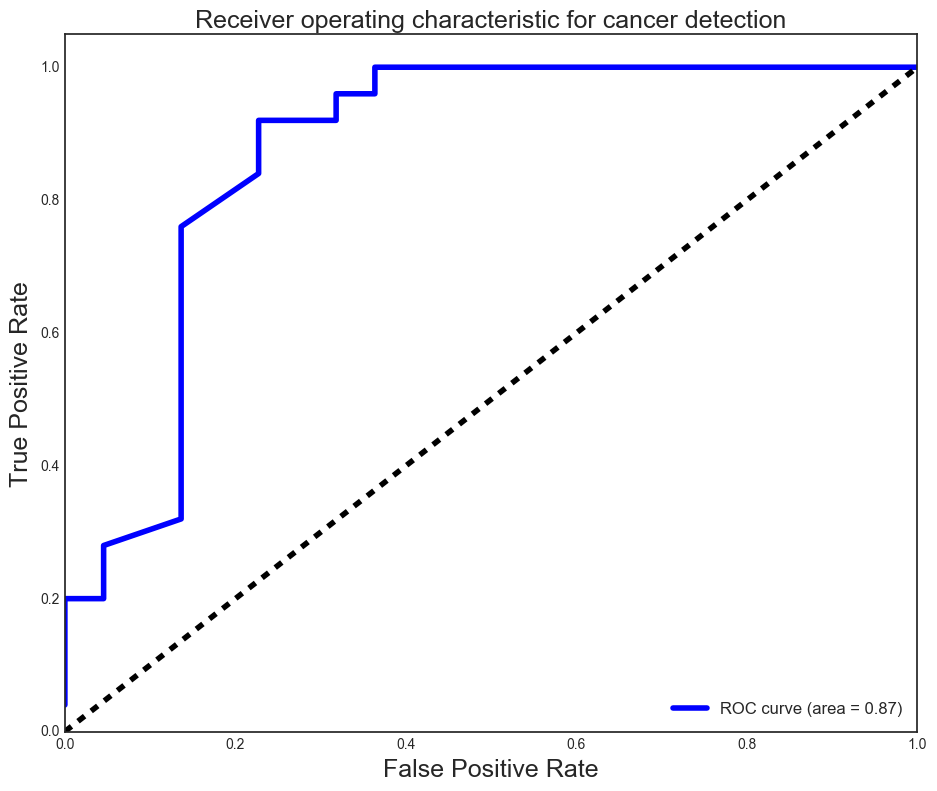

In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline


Y_score = sk_model.decision_function(X_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Y_test, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [32]:
from sklearn.metrics import classification_report

# # 0 means benign, 1 means malignant
# target    = [0, 1, 1, 0, 1, 0, 1, 1, 1]

# #Prediction Results from a Machine Leaning Model
# predicted = [0, 0, 1, 1, 1, 0, 1, 1, 1]

# Label the Classifiers
target_names = ['low_salary', 'high_salary']

#Print Classification Report
print classification_report(Y_test, Y_pred, target_names=target_names)

             precision    recall  f1-score   support

 low_salary       0.80      0.89      0.84        27
high_salary       0.83      0.71      0.77        21

avg / total       0.81      0.81      0.81        48



#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [33]:
from sklearn.cross_validation import cross_val_score

print "accuracy score: ", accuracy_score(Y_test, Y_pred)
print "precision score: ", precision_score(Y_test, Y_pred)
print "recall score: ", recall_score(Y_test, Y_pred)
print "roc_auc score: ", roc_auc_score(Y_test, Y_pred)

accuracy score:  0.8125
precision score:  0.833333333333
recall score:  0.714285714286
roc_auc score:  0.801587301587


### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [34]:
lg_model = LogisticRegression(penalty = 'l1', C=1.0)

for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    lg_model.fit(X_train, Y_train)
    predictions = lg_model.predict(X_test)
print "Model score: ", lg_model.score(X_train,Y_train)
print "accuracy score: ", accuracy_score(Y_test, Y_pred)
print "precision score: ", precision_score(Y_test, Y_pred)
print "recall score: ", recall_score(Y_test, Y_pred)
print "roc_auc score: ", roc_auc_score(Y_test, Y_pred)

Model score:  0.84375
accuracy score:  0.8125
precision score:  0.833333333333
recall score:  0.714285714286
roc_auc score:  0.801587301587


In [37]:
#l1 model
scaler = StandardScaler()

Xtr_s = scaler.fit_transform(X_train)
Xte_s = scaler.transform(X_test)

sk_model = LogisticRegression(penalty = 'l1', C=0.1)
sk_model.fit(Xtr_s, Y_train)
Y_pred = sk_model.predict(Xte_s)

print pd.Series(Y_pred).value_counts()
print Y_test.value_counts()

0    33
1    15
dtype: int64
0    27
1    21
Name: high_salary, dtype: int64


In [42]:
from sklearn.metrics import confusion_matrix
# the input format is almost always (test, predict), but always check with documentation!
conmat = np.array(confusion_matrix(Y_test, Y_pred))

confusion = pd.DataFrame(conmat, index=['low_salary', 'high_salary'],
                         columns=['predicted_low', 'predicted_high'])

print confusion
from sklearn.metrics import accuracy_score

acc = accuracy_score(Y_test, Y_pred)

print acc

             predicted_low  predicted_high
low_salary              25               2
high_salary              8              13
0.791666666667


In [35]:
# model.fit(X_scaled, y)

# df = pd.DataFrame({'features' : X.design_info.column_names, 'coef': model.coef_[0,:]})
# df.sort_values('coef', ascending=False, inplace=True)
# df

#### Optional: Continue to incorporate other text features from the title or summary that you believe will predict the salary and examine their coefficients. Take ~100 scraped entries with salaries. Convert them to use with your model and predict the salary. Which entries have the highest predicted salaries?

# Bonus Section: Use Count Vectorizer from scikit-learn to create features from the text summaries. 
- Examine using count or binary features in the model
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are most valuable? 

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform()

for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(model, X_scaled, y, cv=3, scoring=metric)
    print(metric, scores.mean(), scores.std())

TypeError: fit_transform() takes at least 2 arguments (1 given)

In [ ]:
model.fit(X_scaled, y)

df = pd.DataFrame({'features' : vectorizer.get_feature_names(), 'coef': model.coef_[0,:]})
df.sort_values('coef', ascending=False, inplace=True)

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
# retest L1 and L2 regularization
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV()


Score: | /24
------|-------
Identify: Problem Statement and Hypothesis | 
Acquire: Import Data using BeautifulSoup| 
Parse: Clean and Organize Data| 
Model: Perform Logistic Regression| 
Evaluate: Logistic Regression Results	|
Present: Blog Report with Findings and Recommendations		| 
Interactive Tableau visualizations | 
Regularization |
Bonus: Countvectorizer  | 